In [2]:
# 1. 看看HLDA和LLDA
# HLDA不用写K，用propagation试试
# 2. 文本数量不够的影响，这10篇内容相似
# 3. 每次结果不同，需要重复计算取平均?


# TODO: corpus加入

import os
import re
import sys

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from sklearn.cluster import AffinityPropagation
import csv

csv.field_size_limit(sys.maxsize)

document_path = "/Users/zhouyou/Downloads/doc/docsent"
summ_path = "/Users/zhouyou/Downloads/Archive/"
corpus_add = "/Users/zhouyou/Downloads/doc/corpus_add"


def readfile(path):
    # 遍历文件夹
    files = os.listdir(path)
    files.sort()
    for file in files:
        raw_text = ''
        raw_text_list = []
        if not os.path.isdir(file):
            # print("File name: " + file)
            f = open(path + "/" + file)
            for line in f.readlines():
                searchObj = re.findall(r'SNO=(.*?)>(.*?)</S>', line)
                if searchObj:
                    # print(searchObj)
                    # print(searchObj[0][0])
                    if searchObj[0][0] == "\"1\"":
                        raw_text = raw_text + searchObj[0][1] + '.' + ' '
                        raw_text_list.append(searchObj[0][1])
                    else:
                        raw_text = raw_text + searchObj[0][1] + ' '
                        raw_text_list.append(searchObj[0][1])
                    # print(s)
            yield file, raw_text, raw_text_list


# 读原文的文件.
per_raw_text = readfile(document_path)

all_raw_text = []
all_filenames = []
all_raw_text_list = []

for filename, raw_text, raw_text_list in per_raw_text:
    all_filenames.append(filename)
    all_raw_text.append(raw_text)
    all_raw_text_list.append(raw_text_list)

# print(all_raw_text)
# print(len(all_raw_text))

tokenizer = RegexpTokenizer(r'\w+')

en_stop = get_stop_words('en')

# p_stemmer = PorterStemmer()
# p_stemmer = SnowballStemmer('english')

# wordnet 提取词干效果更好
p_stemmer = WordNetLemmatizer()

# texts 才是最后要放入dic的list

# 目标文本加入corpus
texts = []
for i in all_raw_text:
    tokens = tokenizer.tokenize(i)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    stemmed_tokens = [p_stemmer.lemmatize(i) for i in stopped_tokens]
    # print(stemmed_tokens)
    texts.append(stemmed_tokens)
    break

# # 随机文本加入corpus
# corpus_add_files = os.listdir(corpus_add)
# firstFile = False
#
# for file in corpus_add_files:
#     try:
#         corpus_add_file = open(corpus_add + "/" + file)
#         # print(corpus_add_file)
#         for line in corpus_add_file.readlines():
#             # print(line)
#             tokens = tokenizer.tokenize(line)
#             stopped_tokens = [i for i in tokens if not i in en_stop]
#             stemmed_tokens = [p_stemmer.lemmatize(i) for i in stopped_tokens]
#
#         texts.append(stemmed_tokens)
#         # print(len(stemmed_tokens))
#         # break
#     except:
#         pass

# exit(0)

import csv
csvFile = open("/Users/zhouyou/Downloads/all-the-news/articles1.csv", "r")
reader = csv.reader(csvFile)
csv.field_size_limit(sys.maxsize)

for item in reader:
    if reader.line_num == 1:
        continue
    else:
        if reader.line_num > 1000:
            break
        # print(item[9])
        line = item[9]
        tokens = tokenizer.tokenize(line)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.lemmatize(i) for i in stopped_tokens]

    texts.append(stemmed_tokens)



print(len(texts))
# print(texts[0])
# print(texts[1])
# print("\n")
# print(len(texts))

# AP算法计算聚类中心数
# ap = AffinityPropagation(preference=-50).fit()
# cluster_centers_indices = ap.cluster_centers_indices_
# labels = ap.labels_
#
# n_clusters_ = len(cluster_centers_indices)
#
# print(n_clusters_)
#
# sys.exit(0)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=800, id2word=dictionary, passes=20)

# print(ldamodel.print_topics(num_topics=10, num_words=5))

doc_select = texts[0]
doc_select_list = all_raw_text_list[0]
print(all_raw_text[0])
# print(doc_select)
# print(len(all_raw_text_list))

doc_bow = dictionary.doc2bow(doc_select)

print("\n\n")

print("summary topic: ")
summary_topic = ldamodel.get_document_topics(doc_bow)
print(summary_topic)
a, b = ldamodel.get_document_topics(doc_bow)[0]
# print(ldamodel.print_topic(topicno=a))
print("\n")

# for i in range(len(texts)):
#     temp = dictionary.doc2bow(texts[i])
#     print(ldamodel.get_document_topics(temp))
#
#
#
# sys.exit()


filename = all_filenames[0]
searchObj = re.findall(r'-(.*)_', filename)
extract_folder_name = searchObj[0][:-2]
file = filename[2:-7]

archive_files = os.listdir(summ_path)
archive_files.sort()

temp = []

for archive_file in archive_files:
    path = summ_path + archive_file + "/extract/" + extract_folder_name
    try:
        # print("File name: " + file)
        # print(path + "/" + file + "extract")
        f = open(path + "/" + file + "extract")
        summ = ''
        for line in f.readlines():
            # print(line)
            searchObj = re.findall(r'SNO="(.*)"', line)
            if searchObj:
                # print(int(searchObj[0]))
                summ = summ + (doc_select_list[int(searchObj[0]) - 1])
        # print(archive_file + ": " + ",".join(summ) + "\n")
        print(archive_file + ": ")
        # print(summ)

        summ_tokens = tokenizer.tokenize(summ)
        summ_stopped_tokens = [i for i in summ_tokens if not i in en_stop]
        # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        summ_stemmed_tokens = [p_stemmer.lemmatize(i) for i in summ_stopped_tokens]

        # summ_corpus = [dictionary.doc2bow(text) for text in summ]

        # generate LDA model
        # summ_ldamodel = models.ldamodel.LdaModel(summ_corpus, num_topics=2, id2word=dictionary, passes=20)

        # print(summ_ldamodel.print_topics(num_topics=1, num_words=5))
        # print(summ)

        # print(summ_stemmed_tokens)

        summ_bow = dictionary.doc2bow(summ_stemmed_tokens)
        # print(summ_bow)
        
        res = ldamodel.get_document_topics(bow=summ_bow, minimum_probability=0.01)

        temp.append(res)
        
        print(res)

#         print("\n")

    except Exception as e:
        pass


1000
 Chief Executive to renew ties with our trading partners . The Chief Executive , Mr Tung Chee Hwa , will visit Malaysia , Singapore , the United States , Japan , Belgium and the UK in the next two months to renew ties with our trading partners and update them on developments in Hong Kong after the handover . During these visits , Mr Tung will call on political and business leaders , and brief them on the smooth transition in Hong Kong to demonstrate our pride to return to China and our confidence in  "Hong Kong people ruling Hong Kong " under the  "one country , two systems " concept . Mr Tung will be in Kuala Lumpur on September 3 and call on Prime Minister Dr Mahathir Mohamad . He will be in Singapore on September 4 and 5 and call on Prime Minister Goh Chok Tong . Mr Tung will be in the United States from September 9 to 11 . He will visit Washington and New York . In Washington , Mr Tung looks forward to meeting with President Clinton . Mr Tung will also officiate at the opening

[(5, 0.13741584), (275, 0.053073123), (280, 0.0109643135), (623, 0.7259697), (741, 0.041908335)]
S-E-C_2___-60W-LDC_J001: 
[(5, 0.22010307), (275, 0.041309036), (623, 0.65791345), (741, 0.07344317)]
S-E-C_2___-60W-LDC_J002: 
[(5, 0.13874215), (275, 0.03241432), (404, 0.02360647), (623, 0.7024771), (741, 0.06865797)]
S-E-C_2___-70S-LDC_ALLJ: 
[(5, 0.1666596), (275, 0.03652454), (404, 0.014868456), (623, 0.70426935), (741, 0.067064404)]
S-E-C_2___-70S-LDC_J000: 
[(5, 0.15713583), (275, 0.041505832), (306, 0.01016636), (404, 0.015879314), (623, 0.72054255), (741, 0.0428264)]
S-E-C_2___-70S-LDC_J001: 
[(5, 0.17381166), (275, 0.03666128), (623, 0.7051641), (741, 0.064627506)]
S-E-C_2___-70S-LDC_J002: 
[(5, 0.16599323), (275, 0.03644743), (404, 0.014877717), (623, 0.7043544), (741, 0.0670555)]
S-E-C_2___-70W-LDC_ALLJ: 
[(5, 0.1730367), (275, 0.039547928), (377, 0.019176535), (623, 0.6847763), (741, 0.07459605)]
S-E-C_2___-70W-LDC_J000: 
[(5, 0.14878395), (275, 0.042917892), (377, 0.0195829),

In [3]:
print(summary_topic)
print(temp)

[(5, 0.17701137), (275, 0.028534157), (404, 0.015247481), (623, 0.7098116), (741, 0.059769347)]
[[(130, 0.04498693), (194, 0.039651576), (390, 0.13192761), (595, 0.045477983), (623, 0.7036841)], [(5, 0.49697343), (525, 0.22570181), (746, 0.13496372)], [(130, 0.045795627), (194, 0.03972738), (390, 0.1305157), (595, 0.04554706), (623, 0.7041426)], [(130, 0.045652736), (194, 0.039644238), (390, 0.13103797), (595, 0.0455652), (623, 0.7038282)], [(130, 0.045737855), (194, 0.039743975), (390, 0.1304043), (595, 0.045617666), (623, 0.7042245)], [(5, 0.1537478), (525, 0.057925086), (623, 0.66371703), (679, 0.062403545)], [(130, 0.04435406), (194, 0.039816685), (390, 0.13122457), (595, 0.04571223), (623, 0.7046193)], [(130, 0.045534637), (194, 0.03966174), (390, 0.1313301), (595, 0.045432683), (623, 0.70376915)], [(130, 0.02026689), (146, 0.04477053), (194, 0.025965355), (275, 0.10095608), (418, 0.049277715), (595, 0.021301476), (623, 0.6207532), (741, 0.08131772), (742, 0.018249758)], [(5, 0.15

In [4]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [31]:
summary_topic_porb = summary_topic
summary_topic_list = []
for i in summary_topic:
    a, b = i
    summary_topic_list.append(a)
print(summary_topic_list)
print(summary_topic_porb)

[5, 275, 404, 623, 741]
[(5, 0.17701137), (275, 0.028534157), (404, 0.015247481), (623, 0.7098116), (741, 0.059769347)]


In [22]:
y = []
count = 0
for i in temp:
    if count%8 == 0:
        judge_topic_list = []
        for j in i:
#             print(j)
            a, b = j
            judge_topic_list.append(a)
#     print(judge_topic_list)
        y.append(jaccard_similarity(summary_topic_list, judge_topic_list))
    count = count + 1
print(x)

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90]


<IPython.core.display.Javascript object>


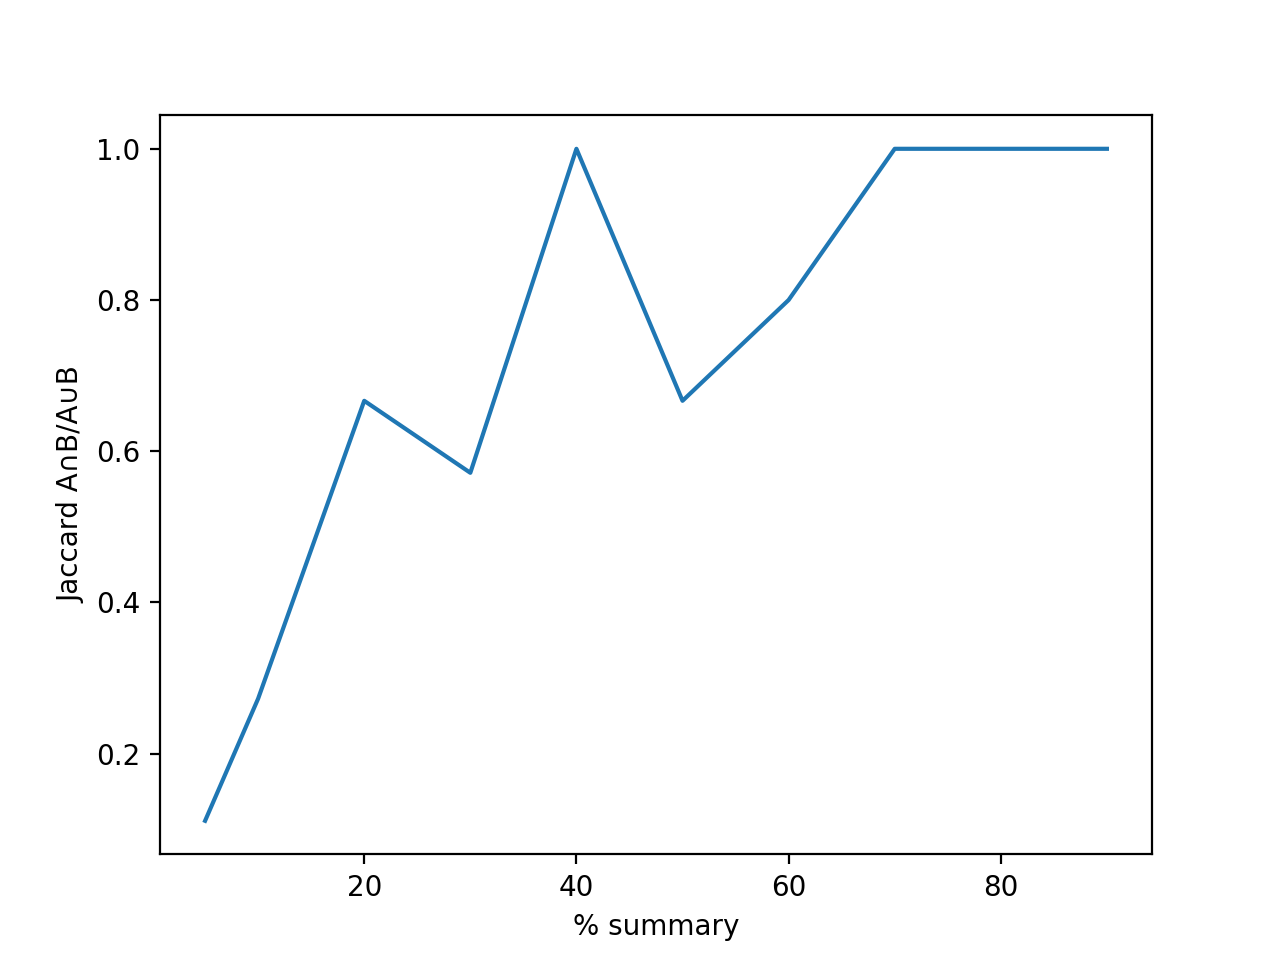

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
 
x = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90]

plt.figure()
plt.plot(x,y)
plt.xlabel("% summary")
plt.ylabel("Jaccard A∩B/A∪B")
plt.show()

[0.9445359718433505, 0.959441163919598, 0.9956716715724819, 0.9969994800555894, 0.9990636, 0.99883306, 0.99965054, 0.9997946, 0.99997956, 0.9999837]


<IPython.core.display.Javascript object>


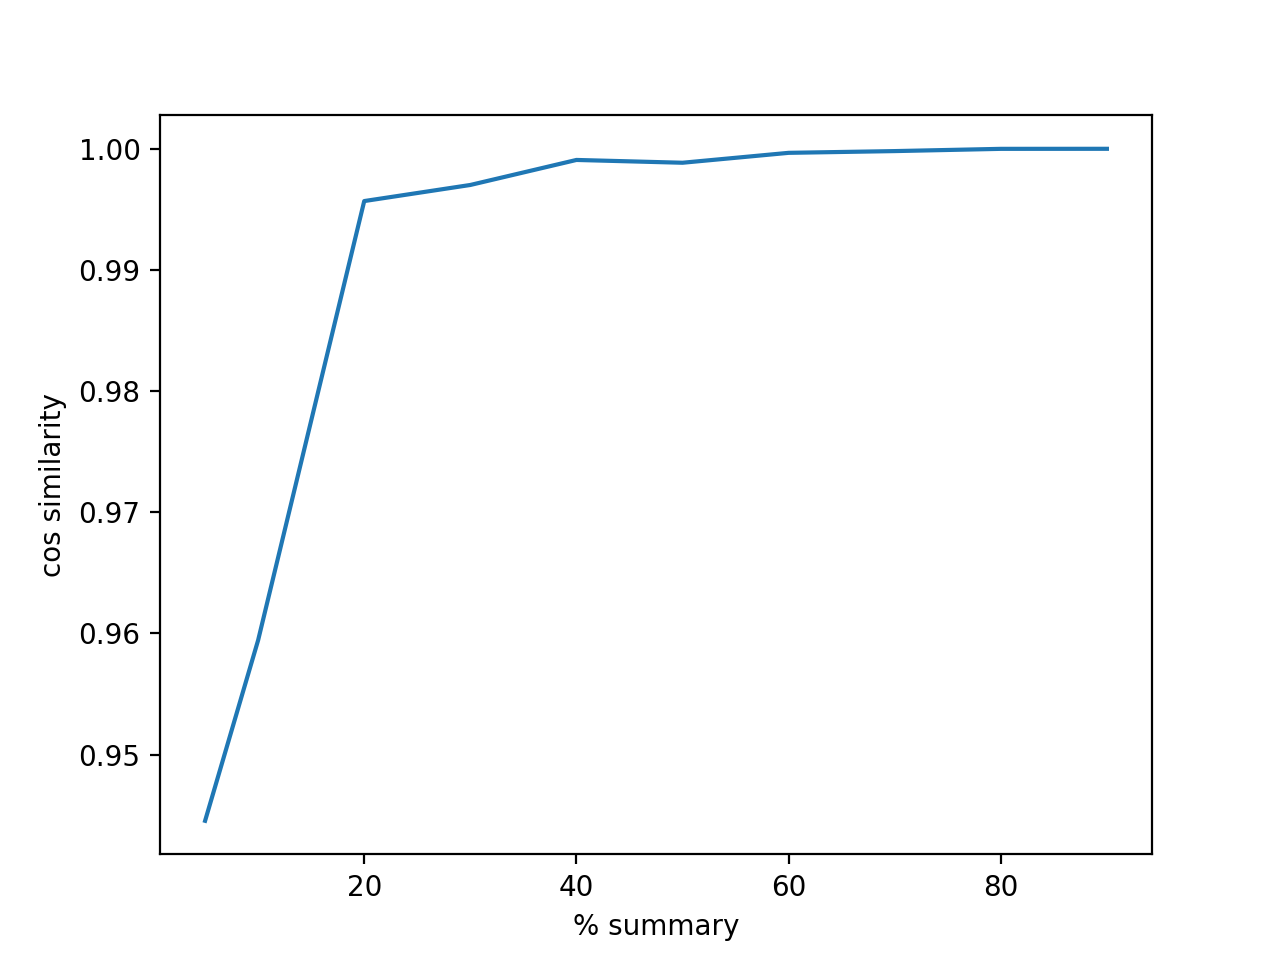

In [74]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = []
count = 0
for i in temp:
    if count%8 == 3:
        #     print(i)
        judge_topic_list = []
        for j in i:
            a, b = j
            judge_topic_list.append(a)
        union_set = set(summary_topic_list).union(set(judge_topic_list))
    
        summary_topic_porb_kv = {}
        for j in summary_topic_porb:
            a, b = j
            summary_topic_porb_kv.setdefault(a, b)
#     print(summary_topic_porb_kv)
        
        judge_topic_list_kv = {}
        for j in i:
            a, b = j
            judge_topic_list_kv.setdefault(a, b)
#     print(judge_topic_list_kv)
    
        summary_topic_porb_cal_coss = []
        judge_topic_list_cal_coss = []
        for k in union_set:
#         print(k)
            summary_topic_porb_cal_coss.append(summary_topic_porb_kv.get(k, 0))
            judge_topic_list_cal_coss.append(judge_topic_list_kv.get(k, 0))
        
        
        cos_sim.append(cosine_similarity(np.array([summary_topic_porb_cal_coss]), np.array([judge_topic_list_cal_coss]))[0][0])
    count = count + 1
    
    
print(cos_sim)
    
# print(summary_topic_porb_cal_coss)
# print(judge_topic_list_cal_coss)
    
x=[5,10,20,30,40,50,60,70,80,90]
plt.figure()
plt.plot(x,cos_sim)
plt.xlabel("% summary")
plt.ylabel("cos similarity")
plt.show() 